In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_ercc'

# Data loading

In [3]:
# Full data
data_klein = dl.load_klein()
sc.pp.filter_genes(data_klein, min_counts=0.01*data_klein.shape[0])

In [4]:
# ercc concentration
df_ercc = dl.load_ercc_info()
data_ercc_dic = {}
ercc_lvl_dic = {}
# 10x from Zheng
data_ercc_dic['10x'] = dl.load_10x_ercc_1k()
_ = sd.get_info(data_ercc_dic['10x'])
ercc_list = list(data_ercc_dic['10x'].var_names) 
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['10x'] = np.array(df.iloc[:,1], dtype=float)
# ercc_lvl_dic['10x'] = ercc_lvl_dic['10x']/10/103*2.6 *1.1/1000 *6.02*1e5
ercc_lvl_dic['10x'] = ercc_lvl_dic['10x']/10/103*3 *1.1/1000 *6.02*1e5
# Klein
data_ercc_dic['klein'] = dl.load_klein_ercc()
_ = sd.get_info(data_ercc_dic['klein'])
ercc_list = list(data_ercc_dic['klein'].var_names)
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['klein'] = np.array(df.iloc[:,0], dtype=float)
ercc_lvl_dic['klein'] = ercc_lvl_dic['klein']/5000/1000 *6.02*1e5
# Svensson
data_ercc_dic['Svensson'] = dl.load_svensson_1x()
_ = sd.get_info(data_ercc_dic['Svensson'])
ercc_list = list(data_ercc_dic['Svensson'].var_names)
df = df_ercc.loc[ercc_list]
ercc_lvl_dic['Svensson'] = np.array(df.iloc[:,0], dtype=float)
ercc_lvl_dic['Svensson'] = ercc_lvl_dic['Svensson']/133*1.1/1000 *6.02*1e5
# # Svensson 2x
# data_ercc_dic['s2'] = dl.load_svensson_2x()
# _ = sd.get_info(data_ercc_dic['s2'])
# ercc_list = list(data_ercc_dic['s2'].var_names)
# df = df_ercc.loc[ercc_list]
# ercc_lvl_dic['s2'] = np.array(df.iloc[:,0], dtype=float)
# ercc_lvl_dic['s2'] = ercc_lvl_dic['s2']/8/37.4*2.6 *1.1/1000 *6.02*1e5

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51
## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23
## Nc=2000, G=90, Nr=1360.01, Nr_bar=15.11


# Figures

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51


/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


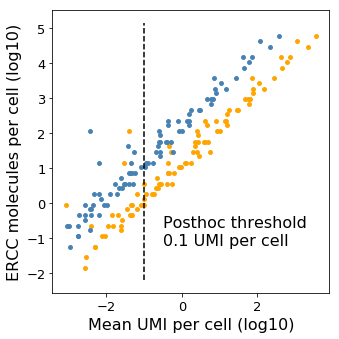

## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23


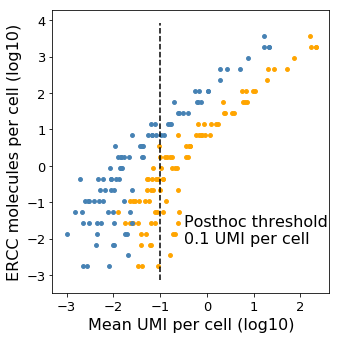

## Nc=2000, G=90, Nr=1360.01, Nr_bar=15.11


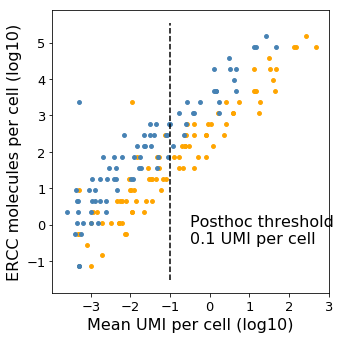

In [95]:
# Mean diagnosis
# data_list = ['10x', 'klein', 'Svensson', 's2']
data_list = ['10x', 'klein', 'Svensson']
# name_dic = {'10x':'Zheng', 'klein': 'Klein', 's1': 'Svensson 1X', 's2': 'Svensson 2X'}
for dname in data_list: 
    # Sub
    Nc,G,Nr,Nr_bar = sd.get_info(data_ercc_dic[dname])
    temp_data = sd.subsample_anndata(data_ercc_dic[dname],Nr/10,Nc,random_state=0,
                                     verbose=False)
    size_factor = sd.dd_size_factor(temp_data,verbose=False)
    M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp_data,verbose=False,size_factor=size_factor)
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    y_val = np.log10(ercc_lvl_dic[dname])
    x_val = np.log10(M_dd[0])
    x_val_sub = np.log10(M_dd_sub[0])
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60)   
    plt.scatter(x_val_sub, y_val, color='steelblue', marker='.', s=60)   
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.annotate('Posthoc threshold\n0.1 UMI per cell', [-0.5, y_min+1], fontsize=16)
    plt.plot([-1, -1], [y_min, y_max], color='k', linestyle='--')
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('ERCC molecules per cell (log10)', fontsize=16)
#     plt.title(name_dic[dname])
    plt.tight_layout()
#     plt.savefig(output_folder+'/mean_%s.png'%dname)
#     plt.savefig(output_folder+'/mean_%s.pdf'%dname)
    plt.show()

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51


/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


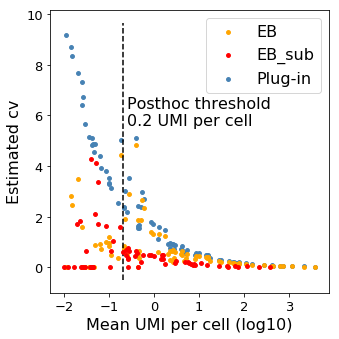

## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23


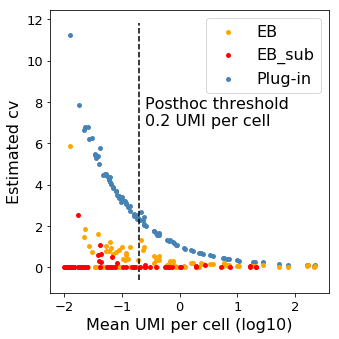

## Nc=2000, G=90, Nr=1360.01, Nr_bar=15.11


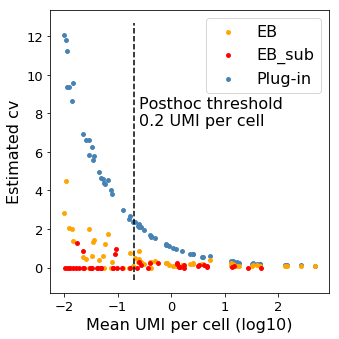

In [21]:
# cv 
# data_list = ['10x', 'klein', 's1', 's2']
data_list = ['10x', 'klein', 'Svensson']
# name_dic = {'10x':'Zheng', 'klein': 'Klein', 's1': 'Svensson 1X', 's2': 'Svensson 2X'}
for dname in data_list: 
    # Sub
    Nc,G,Nr,Nr_bar = sd.get_info(data_ercc_dic[dname])
    temp_data = sd.subsample_anndata(data_ercc_dic[dname],Nr/10,Nc,random_state=0,
                                     verbose=False)
    size_factor = sd.dd_size_factor(temp_data,verbose=False)
    M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp_data,verbose=False,size_factor=size_factor)
    cv_dd_sub = sd.M_to_cv(M_dd_sub)
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    x_val = np.log10(M_dd[0])
    x_val_sub = np.log10(M_dd_sub[0])
    y_val = (cv_dd)
    y_val_sub = (cv_dd_sub)
    y_val_ml = (cv_ml)
    y_val = y_val[x_val>-2]
    y_val_sub = y_val_sub[x_val_sub>-2]
    y_val_ml = y_val_ml[x_val>-2]
    x_val = x_val[x_val>-2]
    x_val_sub = x_val_sub[x_val_sub>-2]
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60, zorder=2, label='EB')
    plt.scatter(x_val_sub, y_val_sub, color='r', marker='.', s=60, zorder=3, label='EB_sub')
    plt.scatter(x_val, y_val_ml, color='steelblue', marker='.', s=60, label='Plug-in')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    y_step = y_max - y_min
    plt.plot([-0.7, -0.7], [y_min, y_max], color='k', linestyle='--')
    plt.annotate('Posthoc threshold\n0.2 UMI per cell', [-0.6, y_min + 0.6*y_step], fontsize=16)
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('Estimated cv', fontsize=16)
#     plt.title(name_dic[dname])
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/cv_%s.png'%dname)
    plt.savefig(output_folder+'/cv_%s.pdf'%dname)
    plt.show()

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51
# time start: 0.0s
n_cell=1015, n_gene=92
# total time: 0.1s
# time start: 0.0s
n_cell=1015, n_gene=92
# total time: 0.1s


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


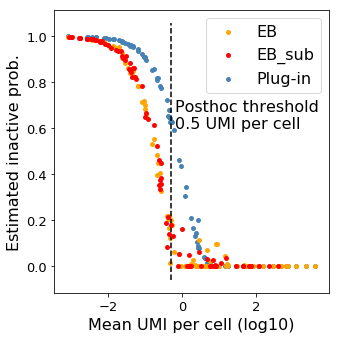

## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23
# time start: 0.0s
n_cell=953, n_gene=92
# total time: 0.1s
# time start: 0.0s
n_cell=953, n_gene=92
# total time: 0.1s


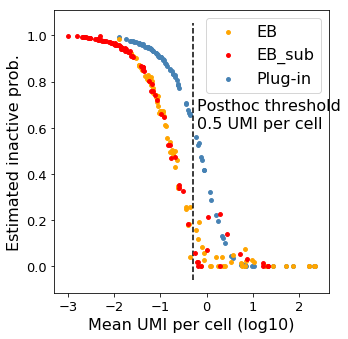

## Nc=2000, G=90, Nr=1360.01, Nr_bar=15.11
# time start: 0.0s
n_cell=2000, n_gene=90
# total time: 0.1s
# time start: 0.0s
n_cell=2000, n_gene=90
# total time: 0.2s


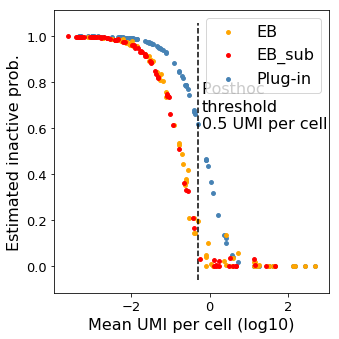

In [20]:
# inactive probability
# data_list = ['10x', 'klein', 's1', 's2']
data_list = ['10x', 'klein', 'Svensson']
# name_dic = {'10x':'Zheng', 'klein': 'Klein', 's1': 'Svensson 1X', 's2': 'Svensson 2X'}
for dname in data_list: 
    # Sub
    Nc,G,Nr,Nr_bar = sd.get_info(data_ercc_dic[dname])
    temp_data = sd.subsample_anndata(data_ercc_dic[dname],Nr/10,Nc,random_state=0,
                                     verbose=False)
    size_factor = sd.dd_size_factor(temp_data,verbose=False)
    M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp_data,verbose=False,size_factor=size_factor)
    p0_ml_sub,p0_dd_sub = sd.dd_inactive_prob(temp_data,
                                              size_factor=size_factor,relative_depth=0.2)
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    p0_ml,p0_dd = sd.dd_inactive_prob(data_ercc_dic[dname],
                                      size_factor=size_factor,relative_depth=0.2)
    x_val = np.log10(M_dd[0])
    x_val_sub = np.log10(M_dd_sub[0])
    y_val = (p0_dd)
    y_val_ml = (p0_ml)
    y_val_sub = (p0_dd_sub)
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60, zorder=2, label='EB')
    plt.scatter(x_val_sub, y_val_sub, color='r', marker='.', s=60, zorder=3, label='EB_sub')
    plt.scatter(x_val, y_val_ml, color='steelblue', marker='.', s=60, label='Plug-in')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    y_step = y_max - y_min
    plt.plot([-0.3, -0.3], [y_min, y_max], color='k', linestyle='--')
    if dname == 'Svensson':
        plt.annotate('Posthoc \nthreshold\n0.5 UMI per cell', [-0.2, 0.6])
    else:
        plt.annotate('Posthoc threshold\n0.5 UMI per cell', [-0.2, 0.6])
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('Estimated inactive prob.', fontsize=16)
#     plt.title(name_dic[dname])
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/p0_%s.png'%dname)
    plt.savefig(output_folder+'/p0_%s.pdf'%dname)
    plt.show()

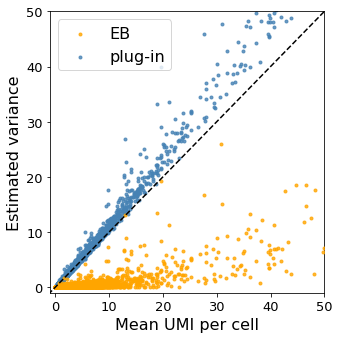

In [25]:
# var Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
    
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
plt.ylim([-1,50])
plt.xlim([-1,50])
plt.xlabel('Mean UMI per cell', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/var_50.png')
plt.savefig(output_folder+'/var_50.pdf')
plt.show()

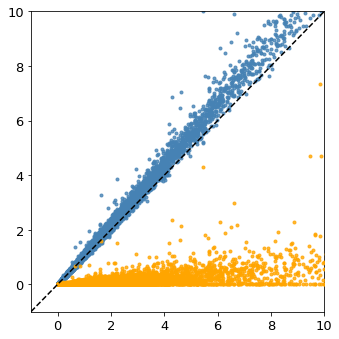

In [26]:
# var Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
    
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
plt.ylim([-1,10])
plt.xlim([-1,10])
# plt.xlabel('Mean UMI counts', fontsize=16)
# plt.ylabel('Estimated variance', fontsize=16)
# plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/var_10.png')
plt.savefig(output_folder+'/var_10.pdf')
plt.show()

# Subsample

In [92]:
# data_list = ['10x', 'klein', 'Svensson']
data_list = ['klein']
# B_list = [200, 300]
B_list = [200]
Nr_bar_list = [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1,]
n_rep = 50
res_dic_cv = {}
res_dic_p0 = {}
for dname in data_list:
    print(dname)
    Nc,G,Nr,Nr_bar = sd.get_info(data_ercc_dic[dname])
    temp_data = data_ercc_dic[dname].copy()
    sc.pp.filter_genes(temp_data, min_counts=1*Nc)
    sc.pp.filter_genes(temp_data, max_counts=10*Nc)
    Nc,G,Nr,Nr_bar = sd.get_info(temp_data)
    for B in B_list:
        res_dic_cv[B] = np.zeros([n_rep, len(Nr_bar_list)], dtype=float)
        res_dic_p0[B] = np.zeros([n_rep, len(Nr_bar_list)], dtype=float)
        for i_Nr_bar_sub,Nr_bar_sub in enumerate(Nr_bar_list):
            Nc_sub = int(B / Nr_bar_sub)
            print(B, Nc_sub, Nr_bar_sub)
            for i_rep in range(n_rep):                           
                temp = sd.subsample_anndata(temp_data,Nr_bar_sub*G,Nc_sub,random_state=i_rep,
                                            verbose=False)
                size_factor = sd.dd_size_factor(temp,verbose=False)
                M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp,verbose=False,
                                                    size_factor=size_factor)
                p0_ml_sub,p0_dd_sub = sd.dd_inactive_prob(temp,
                                                          size_factor=size_factor,
                                                          relative_depth=0.2,
                                                          verbose=False)
                cv_dd_sub = sd.M_to_cv(M_dd_sub)
                res_dic_cv[B][i_rep, i_Nr_bar_sub] = np.mean((cv_dd_sub)**2)
                res_dic_p0[B][i_rep, i_Nr_bar_sub] = \
                    np.mean( (p0_dd_sub - np.exp(-5*M_dd_sub[0]))**2)

klein
## Nc=953, G=92, Nr=1033.32, Nr_bar=11.23
## Nc=953, G=15, Nr=61.78, Nr_bar=4.12
200 800 0.25


/home/martin/single_cell_eb/sceb/scdd.py:163: RuntimeWarning: divide by zero encountered in true_divide
  row_weight = 1/size_factor
/home/martin/single_cell_eb/sceb/scdd.py:430: RuntimeWarning: divide by zero encountered in true_divide
  tc = 1/relative_depth/size_factor


200 666 0.3
200 500 0.4
200 400 0.5
200 333 0.6
200 285 0.7
200 250 0.8
200 200 1


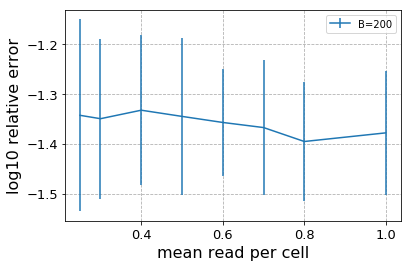

In [93]:
plt.figure()
for B in B_list:
    error_dd = res_dic_cv[B]
    mean_err = np.nanmean(error_dd, axis=0)
    std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)

    plt.errorbar(Nr_bar_list, y_val, y_err*3, label='B=%d'%(B))
plt.xlabel('mean read per cell')
plt.ylabel('log10 relative error')
plt.legend()
plt.grid(linestyle='--')
plt.tight_layout()
# plt.savefig(output_folder + '/cv_tradeoff_%s.pdf'%gene)
plt.show()

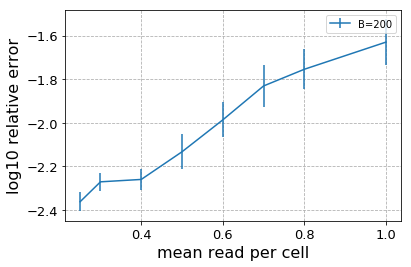

In [94]:
plt.figure()
for B in B_list:
    error_dd = res_dic_p0[B] 
    mean_err = np.nanmean(error_dd, axis=0)
    std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)

    plt.errorbar(Nr_bar_list, y_val, y_err*3, label='B=%d'%(B))
plt.xlabel('mean read per cell')
plt.ylabel('log10 relative error')
plt.legend()
plt.grid(linestyle='--')
plt.tight_layout()
# plt.savefig(output_folder + '/cv_tradeoff_%s.pdf'%gene)
plt.show()

In [ ]:
# for gene in exp_list:
for gene in exp_list:
    temp_res = res_cv[gene]
    B_list = list(temp_res.keys())
    plt.figure()
    for B in B_list:
        cv_ml = temp_res[B]['cv_ml']
        cv_dd = temp_res[B]['cv_dd']
        Nr_bar_new_list = temp_res[B]['Nr_bar_new_list']
        error_dd = (cv_dd - cv_fish_dic[gene])**2 / (cv_fish_dic[gene]**2)
#         error_dd = (cv_dd - cv_dropseq_dic[gene])**2 / (cv_dropseq_dic[gene]**2)
        mean_err = np.nanmean(error_dd, axis=0)
        std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        
        plt.errorbar(Nr_bar_new_list, y_val, y_err*3, label='B=%d'%(B))
    plt.xlabel('mean read per cell')
    plt.ylabel('log10 relative error')
    plt.legend()
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder + '/cv_tradeoff_%s.pdf'%gene)
    plt.show()

In [ ]:
# inactive probability
# data_list = ['10x', 'klein', 's1', 's2']
data_list = ['10x', 'klein', 'Svensson']
# name_dic = {'10x':'Zheng', 'klein': 'Klein', 's1': 'Svensson 1X', 's2': 'Svensson 2X'}
for dname in data_list: 
    for Nr_sub in Nr_sub_list
    # Sub
    Nc,G,Nr,Nr_bar = sd.get_info(data_ercc_dic[dname])
    temp_data = sd.subsample_anndata(data_ercc_dic[dname],Nr/10,Nc,random_state=0,
                                     verbose=False)
    size_factor = sd.dd_size_factor(temp_data,verbose=False)
    M_ml_sub,M_dd_sub = sd.dd_1d_moment(temp_data,verbose=False,size_factor=size_factor)
    p0_ml_sub,p0_dd_sub = sd.dd_inactive_prob(temp_data,
                                              size_factor=size_factor,relative_depth=0.2)
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    p0_ml,p0_dd = sd.dd_inactive_prob(data_ercc_dic[dname],
                                      size_factor=size_factor,relative_depth=0.2)
    x_val = np.log10(M_dd[0])
    x_val_sub = np.log10(M_dd_sub[0])
    y_val = (p0_dd)
    y_val_ml = (p0_ml)
    y_val_sub = (p0_dd_sub)
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60, zorder=2, label='EB')
    plt.scatter(x_val_sub, y_val_sub, color='r', marker='.', s=60, zorder=3, label='EB_sub')
    plt.scatter(x_val, y_val_ml, color='steelblue', marker='.', s=60, label='Plug-in')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    y_step = y_max - y_min
    plt.plot([-0.3, -0.3], [y_min, y_max], color='k', linestyle='--')
    if dname == 'Svensson':
        plt.annotate('Posthoc \nthreshold\n0.5 UMI per cell', [-0.2, 0.6])
    else:
        plt.annotate('Posthoc threshold\n0.5 UMI per cell', [-0.2, 0.6])
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('Estimated inactive prob.', fontsize=16)
#     plt.title(name_dic[dname])
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder+'/p0_%s.png'%dname)
    plt.savefig(output_folder+'/p0_%s.pdf'%dname)
    plt.show()

# Old code

# time start: 0.0s
n_cell=953, n_gene=24515
# total time: 2.4s


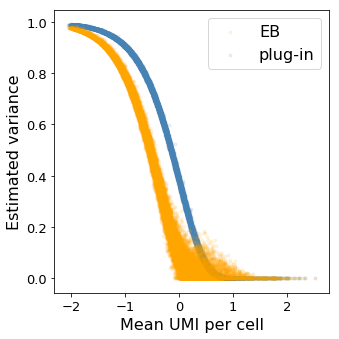

In [196]:
# p0 Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
p0_ml,p0_dd = sd.dd_inactive_prob(data_klein,
                                  size_factor=size_factor,relative_depth=0.4)   
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
x_val = np.log10(M_dd[0])
y_val = (p0_dd)
y_val_ml = (p0_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.1, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.1, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
# plt.ylim([-1,50])
# plt.xlim([-1,50])
plt.xlabel('Mean UMI per cell', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/var_50.png')
# plt.savefig(output_folder+'/var_50.pdf')
plt.show()

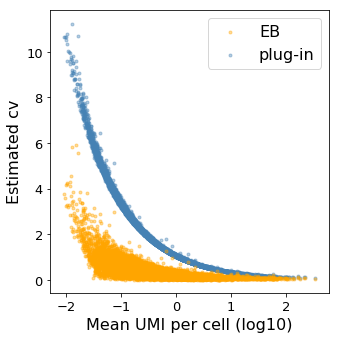

In [195]:
# p0 Klein
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
# p0_ml,p0_dd = sd.dd_inactive_prob(data_klein,
#                                   size_factor=size_factor,relative_depth=0.2)   
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
x_val = np.log10(M_dd[0])[var_dd>1e-8]
y_val = (cv_dd[var_dd>1e-8])
y_val_ml = (cv_ml[var_dd>1e-8])
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.4, marker='.', label='EB', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.4, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [x_min, x_max], linestyle='--', color='k', zorder=11)
# plt.ylim([-1,50])
# plt.xlim([-1,50])
plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/cv.png')
plt.savefig(output_folder+'/cv.pdf')
plt.show()

# Old code

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


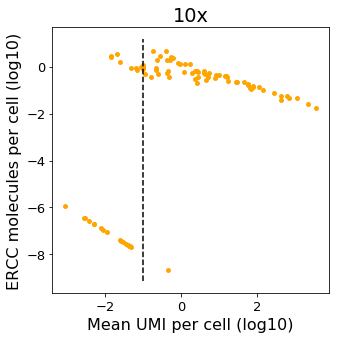

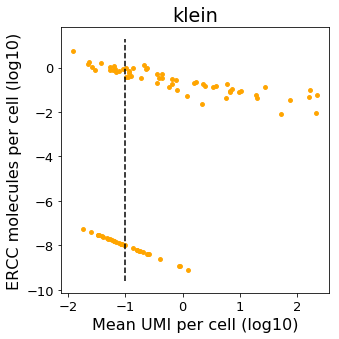

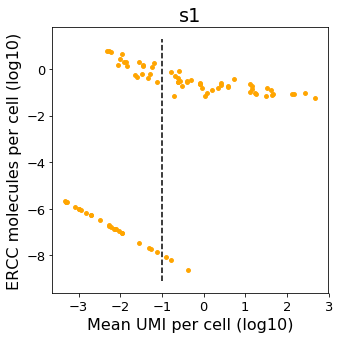

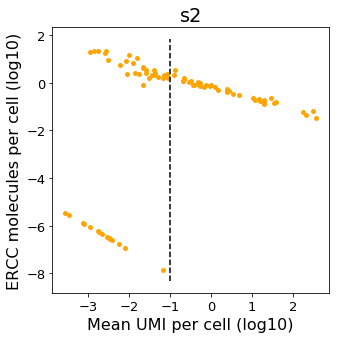

In [52]:
# cv diagnosis
data_list = ['10x', 'klein', 's1', 's2']
for dname in data_list: 
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    x_val = np.log10(M_dd[0])
    y_val = np.log10(cv_dd)
    plt.figure(figsize=[5,5])
    plt.scatter(x_val, y_val, color='orange', marker='.', s=60)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.plot([-1, -1], [y_min, y_max], color='k', linestyle='--')
    plt.xlabel('Mean UMI per cell (log10)', fontsize=16)
    plt.ylabel('ERCC molecules per cell (log10)', fontsize=16)
    plt.title(dname)
    plt.tight_layout()
    # plt.savefig(output_folder+'/ERCC.png')
    # plt.savefig(output_folder+'/ERCC.pdf')
    plt.show()

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


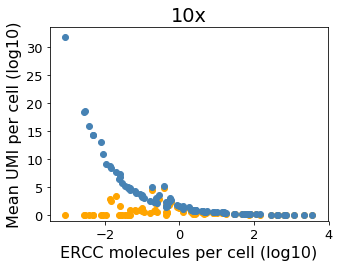

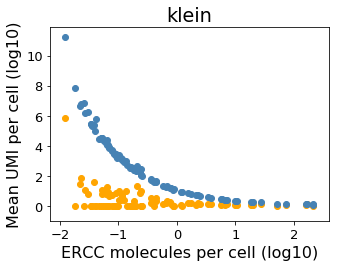

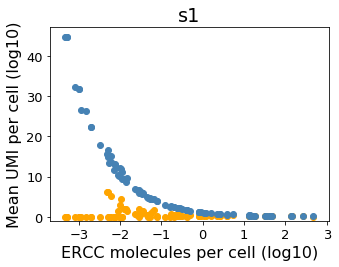

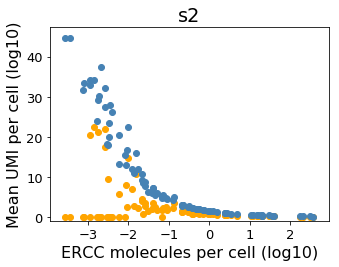

In [30]:
# Mean diagnosis
data_list = ['10x', 'klein', 's1', 's2']
for dname in data_list: 
    # estimation
    size_factor = sd.dd_size_factor(data_ercc_dic[dname],verbose=False)
    M_ml,M_dd = sd.dd_1d_moment(data_ercc_dic[dname],verbose=False,size_factor=size_factor)
    var_dd = sd.M_to_var(M_dd)
    var_ml = sd.M_to_var(M_ml)
    cv_dd = sd.M_to_cv(M_dd)
    cv_ml = sd.M_to_cv(M_ml)
    # figures
    x_val = np.log10(ercc_lvl_dic[dname])
    x_val = np.log10(M_dd[0])
    y_val = np.log10(var_dd)
    y_val = (var_dd)
    y_val = (cv_dd)
    y_val_ml = np.log10(var_ml)
    y_val_ml = (var_ml)
    y_val_ml = (cv_ml)
    plt.figure(figsize=[5,4])
    plt.scatter(x_val, y_val, color='orange')
    plt.scatter(x_val, y_val_ml, color='steelblue')
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.ylim([-1,y_max])
#     plt.xlim([-1,10])
    plt.xlabel('ERCC molecules per cell (log10)', fontsize=16)
    plt.ylabel('Mean UMI per cell (log10)', fontsize=16)
    plt.title(dname)
    plt.tight_layout()
    # plt.savefig(output_folder+'/ERCC.png')
    # plt.savefig(output_folder+'/ERCC.pdf')
    plt.show()

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


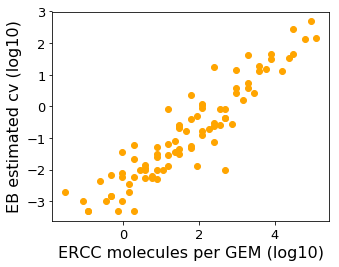

In [4]:
x_val = np.log10(ercc_lvl_dic['s1'])
temp = np.array(data_ercc_dic['s1'].X.mean(axis=0)).reshape([-1])
y_val = np.log10(temp)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.ylim([-0.5,3])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


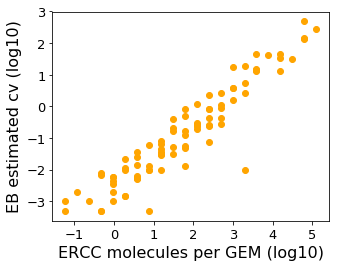

In [6]:
x_val = np.log10(ercc_lvl_dic['s1'])
temp = np.array(data_ercc_dic['s1'].X.mean(axis=0)).reshape([-1])
y_val = np.log10(temp)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.ylim([-0.5,3])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

In [ ]:
data_klein = dl.load_klein()

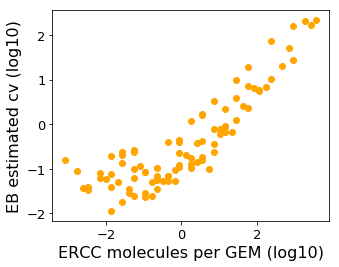

In [257]:
x_val = np.log10(ercc_lvl_klein)
temp = np.array(data_klein_ercc.X.mean(axis=0)).reshape([-1])
y_val = np.log10(temp)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.ylim([-0.5,3])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

In [238]:
data_10x

AnnData object with n_obs × n_vars = 1015 × 92 

In [235]:
# ERCC info
df_ercc = pd.read_csv('/data/martin/single_cell/ERCC_data/ercc-info.txt', sep='\t')
df_ercc = df_ercc.set_index(df_ercc.iloc[:,0])
df_ercc = df_ercc.iloc[:,[2,3]]


In [ ]:
## 
output_folder = '/home/martin/single_cell_eb/figures/figure_smfish'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
data = dl.load_10x_ercc_1k()
# sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
ercc_list = list(data.var_names) 
df = df_ercc.loc[ercc_list]
ercc_lvl = np.array(df.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl = ercc_lvl/10/103*2.6
ercc_lvl = ercc_lvl*1.1/1000
ercc_lvl = ercc_lvl*6.02*1e5
ercc_cv = 1/ np.sqrt(ercc_lvl)

In [3]:
# Full data matrix 
input_folder_klein = '/data/martin/single_cell/klein'
df_klein = pd.read_csv(input_folder_klein + '/data', sep=',')
index_name = list(df_klein.iloc[:,0])
mat_klein = np.array(df_klein.iloc[:,1:].as_matrix(),dtype=int).T
# Convert to AnnData
temp = sp.sparse.csr_matrix(mat_klein)
data_klein = sc.AnnData(temp)
data_klein.var_names = index_name
sc.pp.filter_genes(data_klein, min_counts=0.1*data_klein.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data_klein)

## Nc=953, G=19930, Nr=32245.37, Nr_bar=1.62


In [108]:
# ERCC matrix
input_folder = '/data/martin/single_cell/ERCC_data/ERCC'
df_klein_ercc = pd.read_csv(input_folder + '/klein.txt', sep=' ')
index_name = list(df_klein_ercc.index)
mat_klein_ercc = np.array(df_klein_ercc.as_matrix()).T 
df_ercc_klein = df_ercc.loc[index_name]
ercc_lvl = np.array(df_ercc_klein.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl = ercc_lvl/5000
ercc_lvl = ercc_lvl/1000
ercc_lvl = ercc_lvl*6.02*1e5
# Convert to AnnData 
temp = sp.sparse.csr_matrix(mat_klein_ercc)
data_klein_ercc = sc.AnnData(temp)
data_klein_ercc.var_names = index_name

In [115]:
# Svenssion
# ERCC matrix
input_folder = '/data/martin/single_cell/ERCC_data/ERCC'
df_s1_ercc = pd.read_csv(input_folder + '/svensson1X.txt', sep=' ')
index_name = list(df_s1_ercc.index)
mat_s1_ercc = np.array(df_s1_ercc.as_matrix()).T 
df_ercc_s1 = df_ercc.loc[index_name]
ercc_lvl_s1 = np.array(df_ercc_s1.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl_s1 = ercc_lvl_s1/4
ercc_lvl_s1 = ercc_lvl_s1/1000*1.1
ercc_lvl_s1 = ercc_lvl_s1*6.02*1e5
# Convert to AnnData 
temp = sp.sparse.csr_matrix(mat_s1_ercc)
data_s1_ercc = sc.AnnData(temp)
data_s1_ercc.var_names = index_name

In [116]:
size_factor = sd.dd_size_factor(data_s1_ercc,verbose=False)
M_ml_ercc_s1,M_dd_ercc_s1 = sd.dd_1d_moment(data_s1_ercc,verbose=False,size_factor=size_factor)
var_dd_ercc_s1 = sd.M_to_var(M_dd_ercc_s1)
var_ml_ercc_s1 = sd.M_to_var(M_ml_ercc_s1)
cv_dd_ercc_s1 = sd.M_to_cv(M_dd_ercc_s1)
cv_ml_ercc_s1 = sd.M_to_cv(M_ml_ercc_s1)

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]


In [119]:
# Svenssion
# ERCC matrix
input_folder = '/data/martin/single_cell/ERCC_data/ERCC'
df_s2_ercc = pd.read_csv(input_folder + '/svensson2X.txt', sep=' ')
index_name = list(df_s2_ercc.index)
mat_s2_ercc = np.array(df_s2_ercc.as_matrix()).T 
df_ercc_s2 = df_ercc.loc[index_name]
ercc_lvl_s2 = np.array(df_ercc_s2.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl_s2 = ercc_lvl_s2/8
ercc_lvl_s2 = ercc_lvl_s2/1000*1.1
ercc_lvl_s2 = ercc_lvl_s2*6.02*1e5
# Convert to AnnData 
temp = sp.sparse.csr_matrix(mat_s2_ercc)
data_s2_ercc = sc.AnnData(temp)
data_s2_ercc.var_names = index_name

In [120]:
size_factor = sd.dd_size_factor(data_s2_ercc,verbose=False)
M_ml_ercc_s2,M_dd_ercc_s2 = sd.dd_1d_moment(data_s2_ercc,verbose=False,size_factor=size_factor)
var_dd_ercc_s2 = sd.M_to_var(M_dd_ercc_s2)
var_ml_ercc_s2 = sd.M_to_var(M_ml_ercc_s2)
cv_dd_ercc_s2 = sd.M_to_cv(M_dd_ercc_s2)
cv_ml_ercc_s2 = sd.M_to_cv(M_ml_ercc_s2)

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


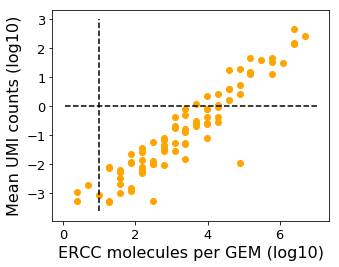

In [172]:
x_val = np.log10(ercc_lvl_s1)
y_val = np.log10(M_dd_ercc_s1[0])
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [0,0], linestyle='--', color='k')
# plt.plot([x_min, x_max], [-0.7,-0.7], linestyle='--', color='k')
plt.plot([1, 1], [y_min, y_max], linestyle='--', color='k')
# plt.plot([0.5, 0.5], [y_min, y_max], linestyle='--', color='k')
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('Mean UMI counts (log10)', fontsize=16)
plt.tight_layout()
plt.show()

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


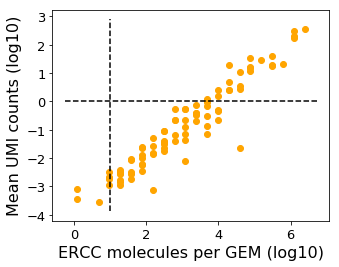

In [121]:
x_val = np.log10(ercc_lvl_s2)
y_val = np.log10(M_dd_ercc_s2[0])
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [0,0], linestyle='--', color='k')
# plt.plot([x_min, x_max], [-0.7,-0.7], linestyle='--', color='k')
plt.plot([1, 1], [y_min, y_max], linestyle='--', color='k')
# plt.plot([0.5, 0.5], [y_min, y_max], linestyle='--', color='k')
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('Mean UMI counts (log10)', fontsize=16)
plt.tight_layout()
plt.show()

# Estimation

In [6]:
# Full data 
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
# ercc
size_factor = sd.dd_size_factor(data_klein_ercc,verbose=False)
M_ml_ercc,M_dd_ercc = sd.dd_1d_moment(data_klein_ercc,verbose=False,size_factor=size_factor)
var_dd_ercc = sd.M_to_var(M_dd_ercc)
var_ml_ercc = sd.M_to_var(M_ml_ercc)
cv_dd_ercc = sd.M_to_cv(M_dd_ercc)
cv_ml_ercc = sd.M_to_cv(M_ml_ercc)

# ERCC

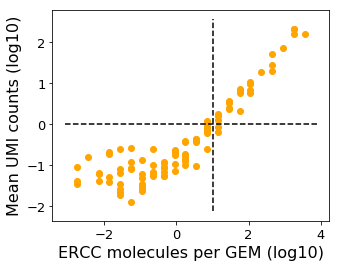

In [66]:
x_val = np.log10(ercc_lvl)
y_val = np.log10(M_dd_ercc[0])
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [0,0], linestyle='--', color='k')
# plt.plot([x_min, x_max], [-0.7,-0.7], linestyle='--', color='k')
plt.plot([1, 1], [y_min, y_max], linestyle='--', color='k')
# plt.plot([0.5, 0.5], [y_min, y_max], linestyle='--', color='k')
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('Mean UMI counts (log10)', fontsize=16)
plt.tight_layout()
plt.show()

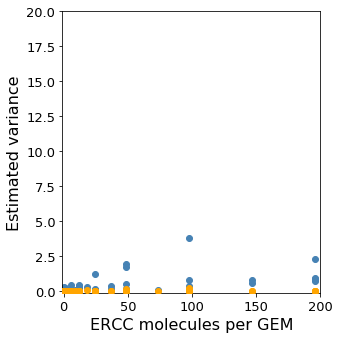

In [225]:
x_val = (ercc_lvl)
y_val = (var_dd_ercc)
y_val_ = (var_ml_ercc)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', zorder=10)
plt.scatter(x_val, y_val_.clip(min=-5), color='steelblue')
# plt.plot([-2,2],[-2,2])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([10, 10], [y_min, y_max], linestyle='--', color='k')
# plt.plot([1, 1], [y_min, y_max], linestyle='--', color='k')
plt.xlim([-1,200])
# plt.xlim([-1,1000])
plt.ylim([-0.1,20])
plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.tight_layout()
plt.show()

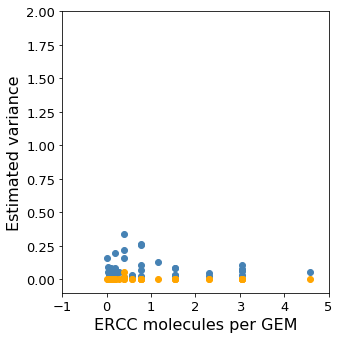

In [223]:
x_val = (ercc_lvl)
y_val = (var_dd_ercc)
y_val_ = (var_ml_ercc)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', zorder=10)
plt.scatter(x_val, y_val_.clip(min=-5), color='steelblue')
# plt.plot([-2,2],[-2,2])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlim([-1,5])
plt.ylim([-0.1,2])
plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.tight_layout()
plt.show()

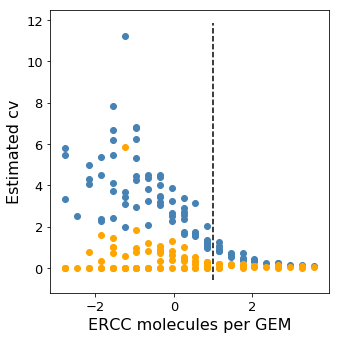

In [78]:
x_val = np.log10(ercc_lvl)
y_val = (cv_dd_ercc)
y_val_ = (cv_ml_ercc)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', zorder=10)
plt.scatter(x_val, y_val_.clip(min=-5), color='steelblue')
# plt.plot([-2,2],[-2,2])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([10, 10], [y_min, y_max], linestyle='--', color='k')
plt.plot([1, 1], [y_min, y_max], linestyle='--', color='k')

# plt.xlim([-5,60])
# plt.xlim([-1,10])
# plt.ylim([-0.1,6])
plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.tight_layout()
plt.show()

In [91]:
np.log10(0.2)

-0.6989700043360187

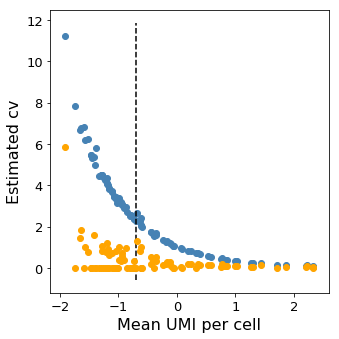

In [92]:
x_val = np.log10(M_dd_ercc[0])
y_val = (cv_dd_ercc)
y_val_ = (cv_ml_ercc)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', zorder=10)
plt.scatter(x_val, y_val_.clip(min=-5), color='steelblue')
# plt.plot([-2,2],[-2,2])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([10, 10], [y_min, y_max], linestyle='--', color='k')
plt.plot([-0.7, -0.7], [y_min, y_max], linestyle='--', color='k')

# plt.xlim([-5,60])
# plt.xlim([-1,10])
# plt.ylim([-0.1,6])
# plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.xlabel('Mean UMI per cell', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.tight_layout()
plt.show()

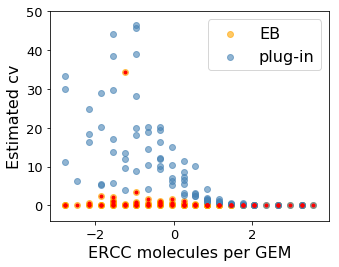

In [12]:
x_val = np.log10(ercc_lvl)
y_val = np.log10(M_dd_ercc[0])
y_val = np.log10(cv_dd_ercc**2)
y_val = (cv_dd_ercc**2)
y_val_ml = np.log10(cv_ml_ercc**2)
y_val_ml = (cv_ml_ercc**2)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange', alpha=0.6, label='EB')
plt.scatter(x_val, y_val, color='r', marker='.', zorder=10)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.6, label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.ylim([-4,50])
plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Full data

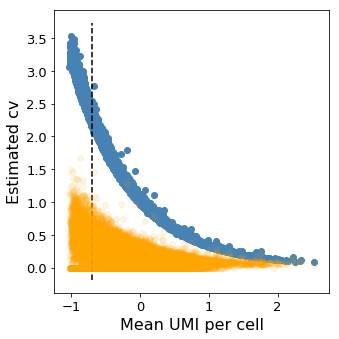

In [105]:
x_val = np.log10(M_dd[0])
y_val = (cv_dd)
y_val_ = (cv_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', zorder=10, alpha=0.1)
plt.scatter(x_val, y_val_.clip(min=-5), color='steelblue')
# plt.plot([-2,2],[-2,2])
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([10, 10], [y_min, y_max], linestyle='--', color='k')
plt.plot([-0.7, -0.7], [y_min, y_max], linestyle='--', color='k')

# plt.xlim([-5,60])
# plt.xlim([-1,10])
# plt.ylim([-0.1,6])
# plt.xlabel('ERCC molecules per GEM', fontsize=16)
plt.xlabel('Mean UMI per cell', fontsize=16)
plt.ylabel('Estimated cv', fontsize=16)
plt.tight_layout()
plt.show()

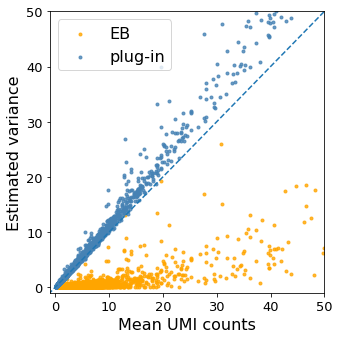

In [14]:
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB')
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
plt.ylim([-1,50])
plt.xlim([-1,50])
plt.xlabel('Mean UMI counts', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

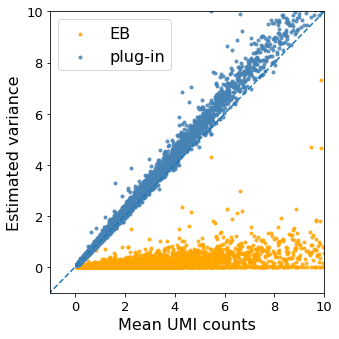

In [15]:
x_val = M_dd[0]
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val, color='orange', alpha=0.8, marker='.', label='EB')
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.8, marker='.', label='plug-in')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
plt.ylim([-1,10])
plt.xlim([-1,10])
plt.xlabel('Mean UMI counts', fontsize=16)
plt.ylabel('Estimated variance', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Old code

In [ ]:
# ERCC 

In [292]:
input_folder = '/data/martin/single_cell/ERCC_data/ERCC'


In [293]:
 



df_klein_ercc = pd.read_csv(input_folder + '/klein.txt', sep=' ')
index_name = list(df_klein_ercc.index)
mat_klein_ercc = np.array(df_klein.as_matrix()).T 
df_ercc_klein = df_ercc.loc[index_name]
ercc_lvl = np.array(df_ercc_klein.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl = ercc_lvl/5000
ercc_lvl = ercc_lvl/1000
ercc_lvl = ercc_lvl*6.02*1e5

In [299]:
temp = sp.sparse.csr_matrix(mat_klein_full)
data_klein_full = sc.AnnData(temp)
data_klein_full.var_names = index_name
sc.pp.filter_genes(data_klein_full,min_counts=0.01*data_klein_full.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data_klein_full)

## Nc=953, G=24515, Nr=32485.73, Nr_bar=1.33


In [300]:
size_factor = sd.dd_size_factor(data_klein_full,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein_full,verbose=False,size_factor=size_factor)
# ercc_lvl = M_ml[0,:]
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)

In [301]:
temp_name = list(data_klein_full.var_names)
ind_ercc = np.zeros([len(temp_name)], dtype=bool)
for i_gene,gene in enumerate(temp_name):
    if 'ERCC-' in gene:
        ind_ercc[i_gene]=True

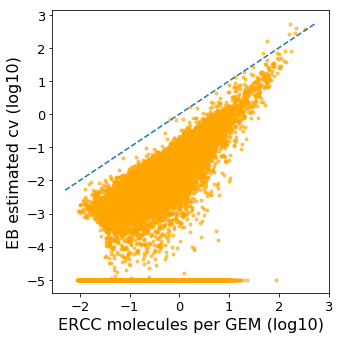

In [303]:
x_val = np.log10(M_dd[0])
# x_val = (M_dd[0])
# x_val = np.log10(ercc_lvl)
# x_val = (ercc_lvl)*0.076
y_val = np.log10(cv_dd)
y_val_ml = np.log10(cv_ml)
y_val = np.log10(var_dd)
y_val_ml = np.log10(var_ml)
# y_val = (var_dd)
# y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', alpha=0.6, marker='.')
# plt.scatter(x_val[ind_ercc], y_val[ind_ercc].clip(min=-5), color='k', alpha=0.6, marker='+')
# plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.6, marker='.')
# plt.scatter(x_val[ind_ercc], y_val_ml[ind_ercc].clip(min=-5), color='r', alpha=0.6, marker='+')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-0.5*x_min, -0.5*x_max], linestyle='--')
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
# plt.ylim([-1,50])
# plt.xlim([-1,50])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
plt.show()

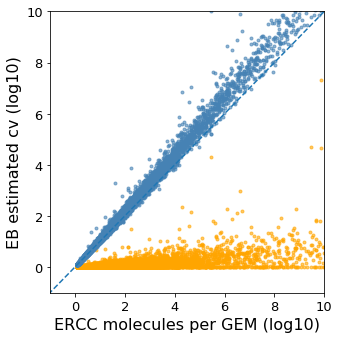

In [258]:
x_val = np.log10(M_dd[0])
x_val = (M_dd[0])
# x_val = np.log10(ercc_lvl)
# x_val = (ercc_lvl)*0.076
y_val = np.log10(cv_dd)
y_val_ml = np.log10(cv_ml)
y_val = np.log10(var_dd)
y_val_ml = np.log10(var_ml)
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', alpha=0.6, marker='.')
# plt.scatter(x_val[ind_ercc], y_val[ind_ercc].clip(min=-5), color='k', alpha=0.6, marker='+')
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.6, marker='.')
# plt.scatter(x_val[ind_ercc], y_val_ml[ind_ercc].clip(min=-5), color='r', alpha=0.6, marker='+')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-0.5*x_min, -0.5*x_max], linestyle='--')
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
plt.ylim([-1,10])
plt.xlim([-1,10])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
plt.show()

In [261]:
df_klein = pd.read_csv(input_folder + '/klein.txt', sep=' ')
index_name = list(df_klein.index)
mat_klein = np.array(df_klein.as_matrix()).T 
df_ercc_klein = df_ercc.loc[index_name]
ercc_lvl = np.array(df_ercc_klein.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl = ercc_lvl/5000
ercc_lvl = ercc_lvl/1000
ercc_lvl = ercc_lvl*6.02*1e5

In [262]:
temp = sp.sparse.csr_matrix(mat_klein)
data_klein = sc.AnnData(temp)
data_klein.var_names = index_name

In [263]:
size_factor = sd.dd_size_factor(data_klein,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data_klein,verbose=False,size_factor=size_factor)
# ercc_lvl = M_ml[0,:]
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)

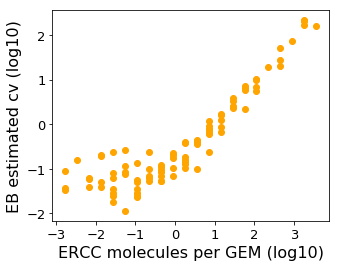

In [264]:
x_val = np.log10(ercc_lvl)
y_val = np.log10(mat_klein.mean(axis=0))
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
plt.show()

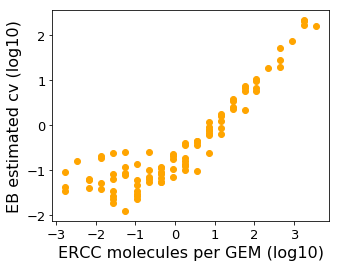

In [175]:
x_val = np.log10(ercc_lvl)
y_val = np.log10(M_dd[0])
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
plt.show()

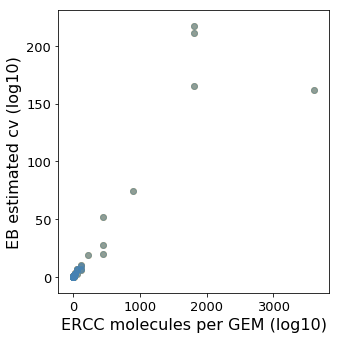

In [289]:
x_val = np.log10(M_dd[0])
x_val = (M_dd[0])
x_val = np.log10(ercc_lvl)
x_val = (ercc_lvl)
# x_val = (ercc_lvl)# *0.076
y_val = np.log10(cv_dd)
y_val_ml = np.log10(cv_ml)
y_val = np.log10(var_dd)
y_val_ml = np.log10(var_ml)

y_val = np.log10(M_dd[0])
y_val = (M_dd[0])
y_val_ml = np.log10(M_dd[0])
y_val_ml = (M_dd[0])
# y_val = (var_dd)
# y_val_ml = (var_ml)
plt.figure(figsize=[5,5])
plt.scatter(x_val, y_val.clip(min=-5), color='orange', alpha=0.6)
plt.scatter(x_val, y_val_ml, color='steelblue', alpha=0.6)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-0.5*x_min, -0.5*x_max], linestyle='--')
# plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
# plt.ylim([-1,500])
# plt.xlim([-1,4000])
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
plt.show()

In [281]:
y_max

485.59828276114627

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51


/home/martin/single_cell_eb/sceb/data_loader.py:348: DeprecationWarning: Use obs_names instead of smp_names, smp_names will be removed in the future.
  data.smp_names = np.genfromtxt(filename_barcodes, dtype=str)


# Channel validation

In [206]:
## 
output_folder = '/home/martin/single_cell_eb/figures/figure_smfish'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
data = dl.load_10x_ercc_1k()
# sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
ercc_list = list(data.var_names) 
df = df_ercc.loc[ercc_list]
ercc_lvl = np.array(df.iloc[:,1], dtype=float)
# ercc_lvl = ercc_lvl/10*1.1/1000*6.02*1e5
ercc_lvl = ercc_lvl/10/103*2.6
ercc_lvl = ercc_lvl*1.1/1000
ercc_lvl = ercc_lvl*6.02*1e5
ercc_cv = 1/ np.sqrt(ercc_lvl)

## Nc=1015, G=92, Nr=10534.54, Nr_bar=114.51


/home/martin/single_cell_eb/sceb/data_loader.py:348: DeprecationWarning: Use obs_names instead of smp_names, smp_names will be removed in the future.
  data.smp_names = np.genfromtxt(filename_barcodes, dtype=str)


In [207]:
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,verbose=False,size_factor=size_factor)
# ercc_lvl = M_ml[0,:]
var_dd = sd.M_to_var(M_dd)
var_ml = sd.M_to_var(M_ml)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)

/home/martin/single_cell_eb/sceb/scdd.py:929: RuntimeWarning: divide by zero encountered in true_divide
  cv_ = np.sqrt(var_)/M[0]


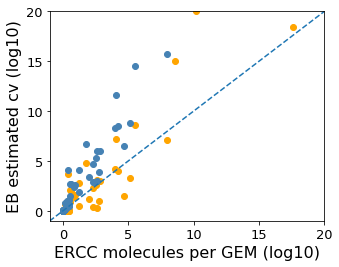

In [215]:
x_val = (ercc_lvl)
x_val = (M_dd[0])
# y_val = np.log10(M_ml[0]+1)
# temp = np.array(data.X.mean(axis=0)).reshape([-1])
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
plt.scatter(x_val, y_val_ml, color='steelblue')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-1,20])
plt.xlim([-1,20])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

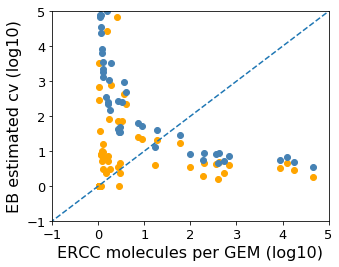

In [220]:
x_val = (ercc_lvl)
x_val = (M_dd[0])
# y_val = np.log10(M_ml[0]+1)
# temp = np.array(data.X.mean(axis=0)).reshape([-1])
y_val = (cv_dd)
y_val_ml = (cv_ml)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
plt.scatter(x_val, y_val_ml, color='steelblue')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-1,5])
plt.xlim([-1,5])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

In [ ]:
x_val = (ercc_lvl)
# y_val = np.log10(M_ml[0]+1)
# temp = np.array(data.X.mean(axis=0)).reshape([-1])
y_val = (var_dd)
y_val_ml = (var_ml)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
plt.scatter(x_val, y_val_ml, color='steelblue')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-x_min, -x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-1,20])
plt.xlim([-1,50])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

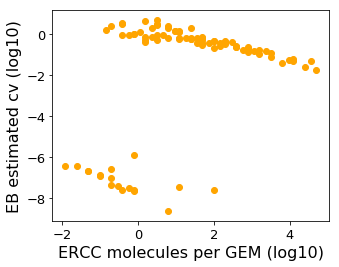

In [201]:
x_val = np.log10(ercc_lvl)
# y_val = np.log10(M_ml[0]+1)
# temp = np.array(data.X.mean(axis=0)).reshape([-1])
y_val = np.log10(cv_dd)
y_val = np.log10(var_dd)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val.clip(), color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-x_min, -x_max], linestyle='--')
# plt.xlim([x_min, x_max])
# plt.ylim([-5,3])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

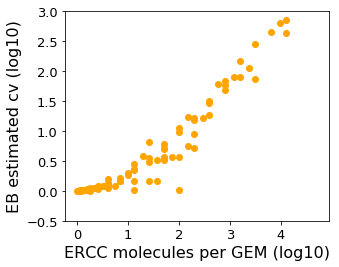

In [192]:
x_val = np.log10(ercc_lvl+1)
# y_val = np.log10(M_ml[0]+1)
temp = np.array(data.X.mean(axis=0)).reshape([-1])
# y_val = np.log10(M_dd[0]+1)
y_val = np.log10(temp+1)
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [-x_min, -x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-0.5,3])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC molecules per GEM (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

In [94]:
x_val

array([5.99708087, 4.79296745, 5.69605131, 4.79296745, 1.78976553,
       2.38650767, 3.28803428, 4.19092844, 3.58895239, 2.38650767,
       2.08725754, 2.686645  , 3.88992643, 2.38650767, 1.78976553,
       4.49194445, 4.49194445, 3.88992643, 5.39502219, 3.28803428,
       2.98722797, 2.08725754, 2.98722797, 4.19092844, 3.58895239,
       2.38650767, 2.08725754, 3.58895239, 1.78976553, 5.99708087,
       4.19092844, 3.28803428, 3.58895239, 3.28803428, 2.686645  ,
       4.19092844, 3.88992643, 5.99708087, 2.98722797, 4.79296745,
       4.49194445, 3.88992643, 5.39502219, 4.49194445, 1.78976553,
       2.98722797, 6.29811065, 3.88992643, 5.09399395, 1.78976553,
       2.38650767, 3.28803428, 4.79296745, 2.98722797, 2.38650767,
       2.686645  , 2.686645  , 1.49572621, 2.686645  , 3.58895239,
       2.98722797, 3.58895239, 1.49572621, 2.98722797, 5.39502219])

In [95]:
ercc_lvl

array([9.93300000e+05, 6.20812500e+04, 4.96650000e+05, 6.20812500e+04,
       6.06262205e+01, 2.42504883e+02, 1.94003906e+03, 1.55203125e+04,
       3.88007812e+03, 2.42504883e+02, 1.21252442e+02, 4.85009766e+02,
       7.76015625e+03, 2.42504883e+02, 6.06262205e+01, 3.10406250e+04,
       3.10406250e+04, 7.76015625e+03, 2.48325000e+05, 1.94003906e+03,
       9.70019531e+02, 1.21252442e+02, 9.70019531e+02, 1.55203125e+04,
       3.88007812e+03, 2.42504883e+02, 1.21252442e+02, 3.88007812e+03,
       6.06262205e+01, 9.93300000e+05, 1.55203125e+04, 1.94003906e+03,
       3.88007812e+03, 1.94003906e+03, 4.85009766e+02, 1.55203125e+04,
       7.76015625e+03, 9.93300000e+05, 9.70019531e+02, 6.20812500e+04,
       3.10406250e+04, 7.76015625e+03, 2.48325000e+05, 3.10406250e+04,
       6.06262205e+01, 9.70019531e+02, 1.98660000e+06, 7.76015625e+03,
       1.24162500e+05, 6.06262205e+01, 2.42504883e+02, 1.94003906e+03,
       6.20812500e+04, 9.70019531e+02, 2.42504883e+02, 4.85009766e+02,
      

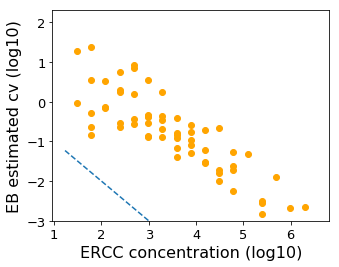

In [86]:
x_val = np.log10(ercc_lvl).reshape([-1,1])
y_val = 2*np.log10(cv_dd)
# x_val = x_val[y_val>-10]
plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
# plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
plt.plot([x_min, x_max], [-x_min, -x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-3,y_max])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
# plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

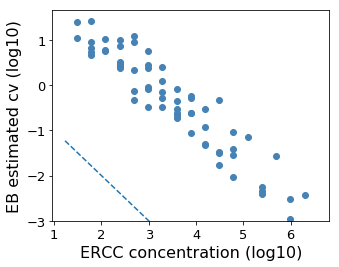

In [88]:
x_val = np.log10(ercc_lvl).reshape([-1,1])
y_val = 2*np.log10(cv_ml)
# x_val = x_val[y_val>-10]

plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='steelblue')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
# plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
plt.plot([x_min, x_max], [-x_min, -x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-3,y_max])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

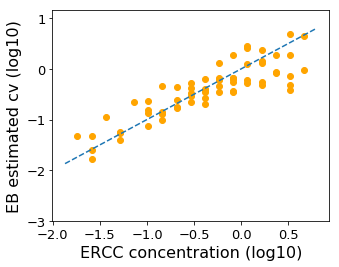

In [73]:
x_val = np.log10(ercc_cv).reshape([-1,1])
y_val = np.log10(cv_dd)
x_val = x_val[y_val>-10]
# y_val = y_val[y_val>-10]
# reg = LinearRegression().fit(x_val, y_val)
# a = reg.coef_[0]
# b = reg.intercept_

plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-3,y_max])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('EB estimated cv (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

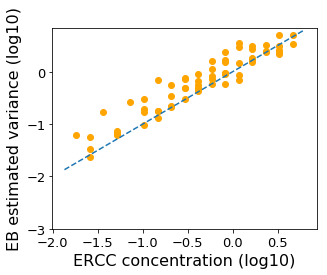

In [72]:
x_val = np.log10(ercc_cv).reshape([-1,1])
y_val = np.log10(cv_ml)
x_val = x_val[y_val>-10]
# y_val = y_val[y_val>-10]
# reg = LinearRegression().fit(x_val, y_val)
# a = reg.coef_[0]
# b = reg.intercept_

plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle='--')

# plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
# plt.xlim([x_min, x_max])
plt.ylim([-3,y_max])
# plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('Drop-seq estimated variance (log10)', fontsize=16)
plt.tight_layout()
# plt.savefig(output_folder+'/ERCC.png')
plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

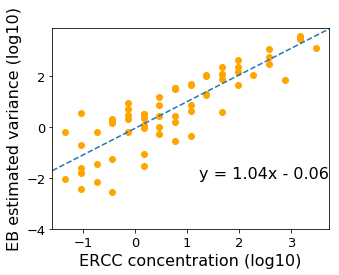

In [64]:
x_val = np.log10(ercc_lvl).reshape([-1,1])
y_val = np.log10(var_dd)
x_val = x_val[y_val>-10]
y_val = y_val[y_val>-10]
reg = LinearRegression().fit(x_val, y_val)
a = reg.coef_[0]
b = reg.intercept_

plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='orange')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
plt.xlim([x_min, x_max])
plt.ylim([-4,y_max])
plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('EB estimated variance (log10)', fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/ERCC.png')
plt.savefig(output_folder+'/ERCC.pdf')
plt.show()

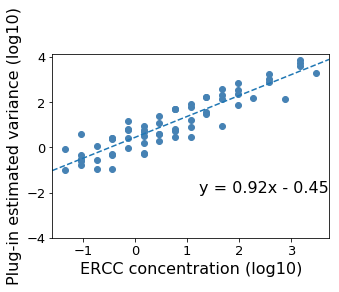

In [63]:
x_val = np.log10(ercc_lvl).reshape([-1,1])
y_val = np.log10(var_ml)
x_val = x_val[y_val>-10]
y_val = y_val[y_val>-10]
reg = LinearRegression().fit(x_val, y_val)
a = reg.coef_[0]
b = reg.intercept_

plt.figure(figsize=[5,4])
plt.scatter(x_val, y_val, color='steelblue')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*a+b,x_max*a+b], linestyle='--')
plt.xlim([x_min, x_max])
plt.ylim([-4,y_max])
plt.annotate('y = %0.2fx - %0.2f'%(a, abs(b)), [x_max - 2.5, -2], fontsize=16)
plt.xlabel('ERCC concentration (log10)', fontsize=16)
plt.ylabel('Plug-in estimated variance (log10)', fontsize=16)
plt.tight_layout()
plt.savefig(output_folder+'/ERCC_ml.png')
plt.savefig(output_folder+'/ERCC_ml.pdf')
plt.show()